In [ ]:
"""
Climate Yield Prediction Model
-----------------------------
Este notebook implementa un modelo predictivo para rendimientos agrícolas basado en variables climáticas.

Características principales:
- Validación cruzada temporal
- Modelos: Linear Regression (baseline), Ridge, Random Forest, XGBoost, Gradient Boosting
- Métricas: MAE, RMSE, R2
"""
## Importación de bibliotecas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as XGBoost
import warnings
warnings.filterwarnings('ignore')
import joblib
import os

%matplotlib inline

In [ ]:
## Carga y exploración de datos
# Cargamos el dataset preparado
df = pd.read_csv('Data\Processed\datos_preparado.csv')

# Verificamos que los datos estén ordenados por producto y año
df = df.sort_values(by=['Producto', 'Año'])

# Verificamos las dimensiones
print(f"Dimensiones del DataFrame: {df.shape}")

# Examinamos los primeros registros
print("\nPrimeras filas:")
df.head()


Dimensiones del DataFrame: (5657, 28)

Primeras filas:


,Código del producto (CPC),Producto,Código del año,Año,Produccion(toneladas),Area_cosechada(ha),Rendimiento(kg/ha),temp_media,dias_calefaccion,dias_refrigeracion,...,rango_temp_media,temp_stress,helada_stress,temp_media_prev_year,dias_helada_prev_year,temp_max_prev_year,temp_min_prev_year,dias_calefaccion_prev_year,dias_refrigeracion_prev_year,rendimiento_prev_year
0,1450.0,"Aceitunas, olivas",1980,1980,2255000.0,1156500.0,1949.8,285.602374,1840.170131,167.406658,...,7.115642,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1450.0,"Aceitunas, olivas",1981,1981,1520800.0,2045000.0,743.7,286.153370,1701.725095,181.520258,...,7.484887,1,1,285.602374,46.084803,304.931822,267.255465,1840.170131,167.406658,1949.8
2,1450.0,"Aceitunas, olivas",1982,1982,3337900.0,2045800.0,1631.6,286.366110,1660.305388,201.588274,...,7.114025,1,1,286.153370,47.359136,304.518834,267.626369,1701.725095,181.520258,743.7
3,1450.0,"Aceitunas, olivas",1983,1983,1328400.0,2050400.0,647.9,286.225098,1689.456833,189.695727,...,7.571777,1,1,286.366110,39.719761,304.820828,270.616759,1660.305388,201.588274,1631.6
4,1450.0,"Aceitunas, olivas",1984,1984,3525400.0,2039100.0,1728.9,285.719600,1774.151377,153.548398,...,7.035220,1,1,286.225098,46.498697,305.865789,266.454933,1689.456833,189.695727,647.9


Distribución de productos únicos por año:
     Año  Cantidad de productos únicos
0   1961                            82
1   1962                            82
2   1963                            82
3   1964                            82
4   1965                            82
..   ...                           ...
58  2019                            77
59  2020                            77
60  2021                            78
61  2022                            77
62  2023                            77

[63 rows x 2 columns]


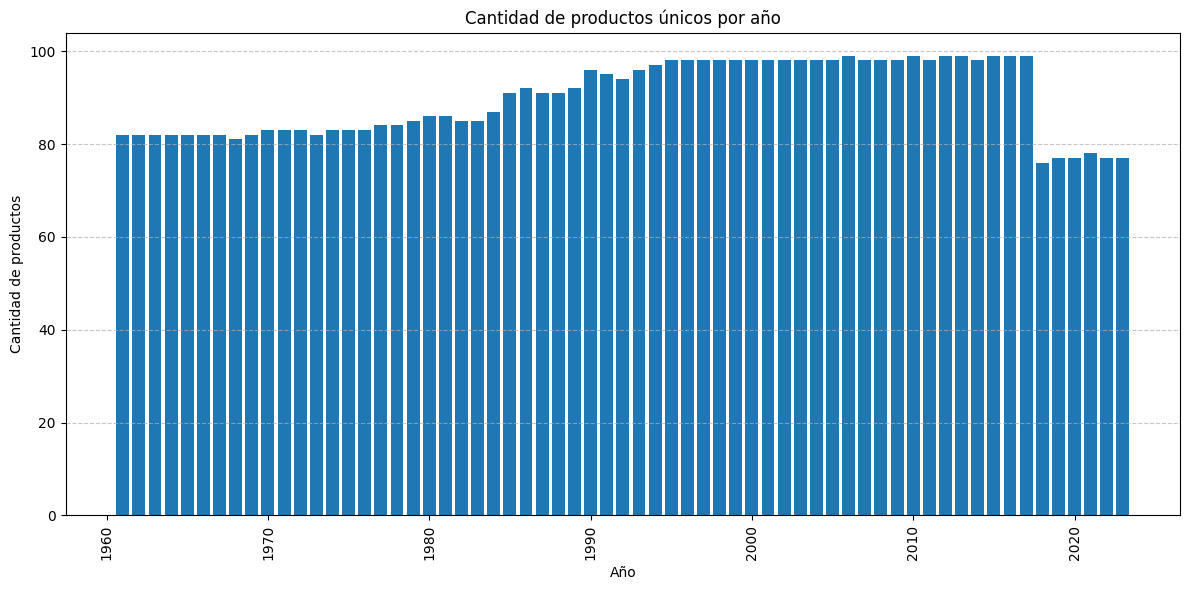


Valores nulos en columnas principales:
Año                        0
Producto                   0
Produccion(toneladas)      0
temp_media                 0
rendimiento_prev_year    105
dtype: int64

Estadísticas descriptivas de la producción:
count    5.657000e+03
mean     6.233138e+05
std      1.488252e+06
min      0.000000e+00
25%      1.142300e+04
50%      7.810000e+04
75%      4.074280e+05
max      1.207000e+07
Name: Produccion(toneladas), dtype: float64


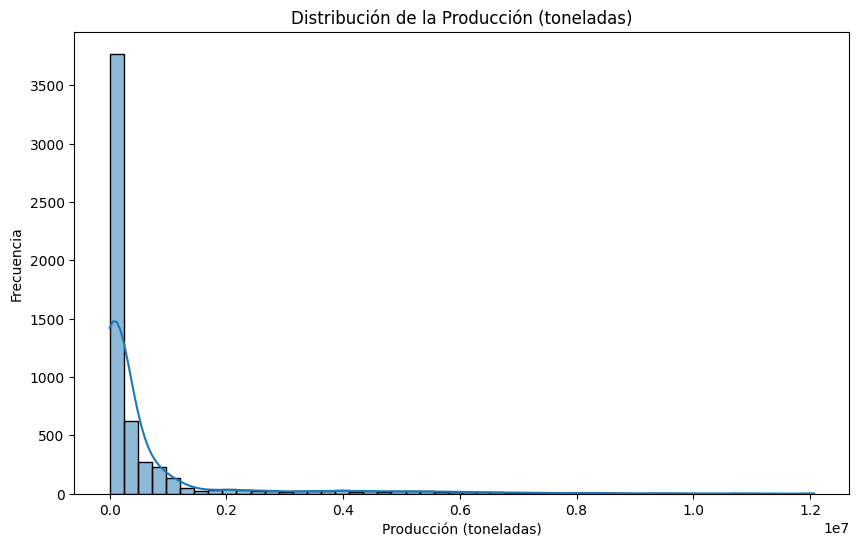

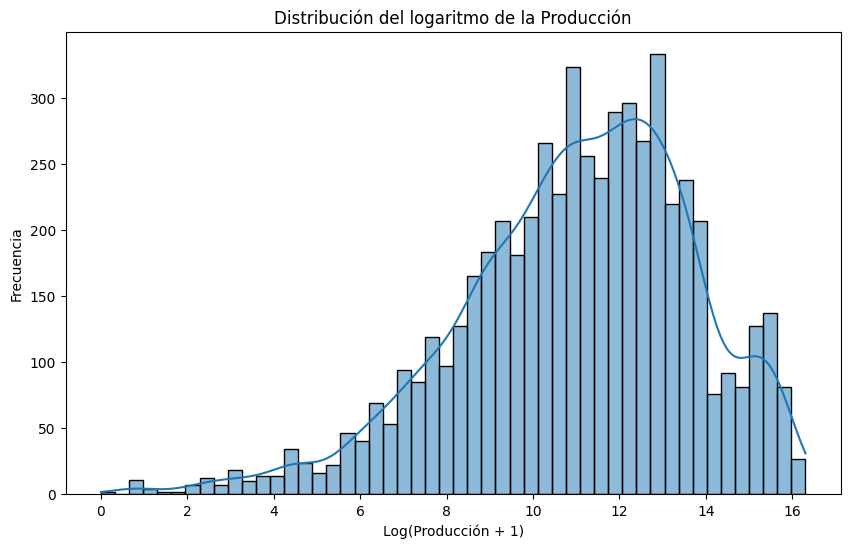

In [3]:
## Análisis de la estructura temporal de los datos

# Creamos una tabla con la distribución de productos por año
productos_por_año = df.groupby('Año')['Producto'].nunique().reset_index()
productos_por_año.columns = ['Año', 'Cantidad de productos únicos']

# Mostramos la tabla
print("Distribución de productos únicos por año:")
print(productos_por_año)

# Visualizamos la distribución
plt.figure(figsize=(12, 6))
plt.bar(productos_por_año['Año'], productos_por_año['Cantidad de productos únicos'])
plt.title('Cantidad de productos únicos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comprobamos si hay valores nulos en las columnas principales
print("\nValores nulos en columnas principales:")
columnas_importantes = ['Año', 'Producto', 'Produccion(toneladas)', 'temp_media', 'rendimiento_prev_year']
print(df[columnas_importantes].isnull().sum())

# Estadísticas descriptivas de la variable objetivo
print("\nEstadísticas descriptivas de la producción:")
print(df['Produccion(toneladas)'].describe())

# Visualizamos la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(df['Produccion(toneladas)'], bins=50, kde=True)
plt.title('Distribución de la Producción (toneladas)')
plt.xlabel('Producción (toneladas)')
plt.ylabel('Frecuencia')
plt.show()

# Verificamos si hay una transformación logarítmica puede normalizar la distribución
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['Produccion(toneladas)']), bins=50, kde=True)
plt.title('Distribución del logaritmo de la Producción')
plt.xlabel('Log(Producción + 1)')
plt.ylabel('Frecuencia')
plt.show()


In [4]:
## Implementación de mejoras según el feedback

### 1. Incorporación de años anteriores para validación cruzada

# Función para generar características de años anteriores (lag features)
def generar_features_historicos(df, columnas_clima, n_years=3):
    """
    Genera características basadas en datos históricos de n años anteriores.
    
    Args:
        df: DataFrame con datos ordenados por producto y año
        columnas_clima: Lista de columnas climáticas para crear lag features
        n_years: Número de años anteriores a considerar
    
    Returns:
        DataFrame con nuevas características de años anteriores
    """
    # Hacemos una copia para no modificar el original
    df_new = df.copy()
    
    # Para cada producto, creamos características de años anteriores
    productos = df_new['Producto'].unique()
    
    all_dfs = []
    
    for producto in productos:
        df_prod = df_new[df_new['Producto'] == producto].copy()
        df_prod = df_prod.sort_values('Año')
        
        # Para cada año de lag (1 a n_years)
        for lag in range(1, n_years + 1):
            # Para rendimiento y producción anteriores
            df_prod[f'produccion_prev_{lag}_year'] = df_prod['Produccion(toneladas)'].shift(lag)
            df_prod[f'rendimiento_prev_{lag}_year'] = df_prod['Rendimiento(kg/ha)'].shift(lag)
            df_prod[f'area_prev_{lag}_year'] = df_prod['Area_cosechada(ha)'].shift(lag)
            
            # Para variables climáticas seleccionadas
            for col in columnas_clima:
                df_prod[f'{col}_prev_{lag}_year'] = df_prod[col].shift(lag)
        
        all_dfs.append(df_prod)
    
    # Combinamos todos los DataFrames
    result_df = pd.concat(all_dfs)
    
    # Eliminamos filas con NaN (serán los primeros n_years de cada producto)
    result_df = result_df.dropna()
    
    return result_df

# Columnas climáticas a considerar para generar lag features
columnas_clima = [
    'temp_media', 'dias_helada', 'temp_max', 'temp_min',
    'dias_calefaccion', 'dias_refrigeracion', 'temp_max_media', 
    'temp_min_media', 'rango_temp_anual', 'helada_stress'
]

# Generamos features de hasta 5 años anteriores
df_with_lags = generar_features_historicos(df, columnas_clima, n_years=5)

print(f"Dimensiones después de crear features de años anteriores: {df_with_lags.shape}")
print("\nNuevas columnas agregadas:")
new_cols = [col for col in df_with_lags.columns if 'prev' in col and 'prev_year' not in col]
print(new_cols)


Dimensiones después de crear features de años anteriores: (5132, 93)

Nuevas columnas agregadas:
['produccion_prev_1_year', 'rendimiento_prev_1_year', 'area_prev_1_year', 'temp_media_prev_1_year', 'dias_helada_prev_1_year', 'temp_max_prev_1_year', 'temp_min_prev_1_year', 'dias_calefaccion_prev_1_year', 'dias_refrigeracion_prev_1_year', 'temp_max_media_prev_1_year', 'temp_min_media_prev_1_year', 'rango_temp_anual_prev_1_year', 'helada_stress_prev_1_year', 'produccion_prev_2_year', 'rendimiento_prev_2_year', 'area_prev_2_year', 'temp_media_prev_2_year', 'dias_helada_prev_2_year', 'temp_max_prev_2_year', 'temp_min_prev_2_year', 'dias_calefaccion_prev_2_year', 'dias_refrigeracion_prev_2_year', 'temp_max_media_prev_2_year', 'temp_min_media_prev_2_year', 'rango_temp_anual_prev_2_year', 'helada_stress_prev_2_year', 'produccion_prev_3_year', 'rendimiento_prev_3_year', 'area_prev_3_year', 'temp_media_prev_3_year', 'dias_helada_prev_3_year', 'temp_max_prev_3_year', 'temp_min_prev_3_year', 'dias_

In [5]:
### 2. Preparación de características y target correctamente

# Definimos las características que usaremos para el modelo
# IMPORTANTE: Eliminamos características del mismo año que no estarían disponibles al momento de predecir

# Características climáticas del mismo año que NO podemos usar para predecir
caracteristicas_mismo_ano = [
    'temp_media', 'dias_calefaccion', 'dias_refrigeracion', 'dias_helada',
    'temp_max', 'temp_max_media', 'temp_max_min', 'temp_min_max', 
    'temp_min_media', 'temp_min', 'rango_temp_anual', 'rango_temp_media',
    'temp_stress', 'helada_stress', 'Area_cosechada(ha)', 'Rendimiento(kg/ha)'  
]

# Variables que sí podemos usar (años anteriores y características de producto)
caracteristicas = [col for col in df_with_lags.columns if any(s in col for s in ['prev_1', 'prev_2', 'prev_3', 'prev_4', 'prev_5'])]

# Agregamos características categóricas y de identificación
caracteristicas.append('Código del producto (CPC)')

# Variable objetivo (usamos transformación logarítmica para normalizar la distribución)
df_with_lags['log_produccion'] = np.log1p(df_with_lags['Produccion(toneladas)'])
y = df_with_lags['log_produccion']  # Usamos log para mejorar la distribución

# Características 
X = df_with_lags[caracteristicas]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# Mostramos las primeras filas de X
X.head()


Dimensiones de X: (5132, 66)
Dimensiones de y: (5132,)


,produccion_prev_1_year,rendimiento_prev_1_year,area_prev_1_year,temp_media_prev_1_year,dias_helada_prev_1_year,temp_max_prev_1_year,temp_min_prev_1_year,dias_calefaccion_prev_1_year,dias_refrigeracion_prev_1_year,temp_max_media_prev_1_year,...,dias_helada_prev_5_year,temp_max_prev_5_year,temp_min_prev_5_year,dias_calefaccion_prev_5_year,dias_refrigeracion_prev_5_year,temp_max_media_prev_5_year,temp_min_media_prev_5_year,rango_temp_anual_prev_5_year,helada_stress_prev_5_year,Código del producto (CPC)
5,3525400.0,1728.9,2039100.0,285.719600,42.210031,305.231049,270.067672,1774.151377,153.548398,289.397374,...,46.084803,304.931822,267.255465,1840.170131,167.406658,289.336744,282.221102,37.676357,1.0,1450.0
6,1989500.0,970.0,2051000.0,286.124252,45.443254,305.589390,263.417360,1774.662644,214.348113,290.049869,...,47.359136,304.518834,267.626369,1701.725095,181.520258,290.060759,282.575872,36.892466,1.0,1450.0
7,2556800.0,1239.4,2063000.0,286.146364,44.838940,304.465144,267.356796,1739.040312,199.283900,289.955129,...,39.719761,304.820828,270.616759,1660.305388,201.588274,290.113220,282.999195,34.204069,1.0,1450.0
8,3879000.0,1885.8,2057000.0,286.276671,43.947476,305.407769,265.399466,1730.599560,229.059075,289.966064,...,46.498697,305.865789,266.454933,1689.456833,189.695727,290.215434,282.643657,39.410855,1.0,1450.0
9,2223700.0,1092.7,2035000.0,286.440905,41.521458,306.265635,269.510350,1659.621254,229.152372,290.232918,...,42.210031,305.231049,270.067672,1774.151377,153.548398,289.397374,282.362154,35.163377,1.0,1450.0


In [6]:
### 3. Función para evaluación correcta con validación cruzada temporal
def evaluar_modelo_cv_temporal(X, y, modelo, n_splits=5, transform_target=True):
    """
    Evalúa un modelo usando validación cruzada temporal.
    
    Args:
        X: Features
        y: Target (log-transformado)
        modelo: Modelo a evaluar
        n_splits: Número de divisiones para la validación cruzada
        transform_target: Si True, se aplica transformación inversa para métricas
    
    Returns:
        dict con métricas de evaluación
    """
    # Creamos el objeto TimeSeriesSplit para validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Métricas para cada fold
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    # Para cada split de validación cruzada
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Aplicamos StandardScaler SOLO a los datos de entrenamiento
        # y luego transformamos los datos de prueba con ese mismo scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamos el modelo
        modelo.fit(X_train_scaled, y_train)
        
        # Predecimos
        y_pred_log = modelo.predict(X_test_scaled)
        
        try:
            # Si es necesario, aplicamos transformación inversa para calcular métricas en la escala original
            if transform_target:
                y_pred = np.expm1(y_pred_log)  # Transformación inversa de log1p
                y_test_original = np.expm1(y_test)
                
                # Calculamos métricas en escala original
                mse = mean_squared_error(y_test_original, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test_original, y_pred)
                r2 = r2_score(y_test_original, y_pred)
            else:
                # Calculamos métricas en escala logarítmica
                mse = mean_squared_error(y_test, y_pred_log)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred_log)
                r2 = r2_score(y_test, y_pred_log)
            
            # Verificación de valores anómalos de R2
            if r2 < -10 or r2 > 10:
                print(f"ADVERTENCIA: Valor R² anómalo detectado: {r2}")
                # Recalculamos R2 manualmente para verificación
                if transform_target:
                    ss_res = np.sum((y_test_original - y_pred) ** 2)
                    ss_tot = np.sum((y_test_original - np.mean(y_test_original)) ** 2)
                else:
                    ss_res = np.sum((y_test - y_pred_log) ** 2)
                    ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
                
                if ss_tot == 0:  # Evitar división por cero
                    r2 = 0
                else:
                    r2 = 1 - (ss_res / ss_tot)
                
                print(f"R² recalculado manualmente: {r2}")
        
        except Exception as e:
            print(f"Error en el cálculo de métricas: {str(e)}")
            # Valores de fallback
            mse = np.nan
            rmse = np.nan
            mae = np.nan
            r2 = np.nan
        
        # Guardamos métricas, asegurándonos que sean valores válidos
        if not np.isnan(r2) and not np.isinf(r2) and -1 <= r2 <= 1:
            mse_scores.append(mse)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            r2_scores.append(r2)
        else:
            print(f"Omitiendo fold con R² inválido: {r2}")
    
    # Si no tenemos scores válidos, retornamos valores por defecto
    if len(r2_scores) == 0:
        return {
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAE': np.nan,
            'R2': 0,  # Valor por defecto para un modelo que no es mejor que predecir la media
            'MSE_std': np.nan,
            'RMSE_std': np.nan,
            'MAE_std': np.nan,
            'R2_std': np.nan
        }
    
    # Retornamos las métricas promedio
    return {
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores),
        'MSE_std': np.std(mse_scores),
        'RMSE_std': np.std(rmse_scores),
        'MAE_std': np.std(mae_scores),
        'R2_std': np.std(r2_scores)
    }


Evaluando modelo con 1 años anteriores...
ADVERTENCIA: Valor R² anómalo detectado: -1065861.4655280493
R² recalculado manualmente: -1065861.4655280493
Omitiendo fold con R² inválido: -1065861.4655280493
ADVERTENCIA: Valor R² anómalo detectado: -37.01390372250023
R² recalculado manualmente: -37.01390372250023
Omitiendo fold con R² inválido: -37.01390372250023
ADVERTENCIA: Valor R² anómalo detectado: -1038555.9080392385
R² recalculado manualmente: -1038555.9080392385
Omitiendo fold con R² inválido: -1038555.9080392385
ADVERTENCIA: Valor R² anómalo detectado: -36.28640513038498
R² recalculado manualmente: -36.28640513038498
Omitiendo fold con R² inválido: -36.28640513038498

Evaluando modelo con 2 años anteriores...
ADVERTENCIA: Valor R² anómalo detectado: -778706.6373055647
R² recalculado manualmente: -778706.6373055647
Omitiendo fold con R² inválido: -778706.6373055647
ADVERTENCIA: Valor R² anómalo detectado: -43.22096445360198
R² recalculado manualmente: -43.22096445360198
Omitiendo f

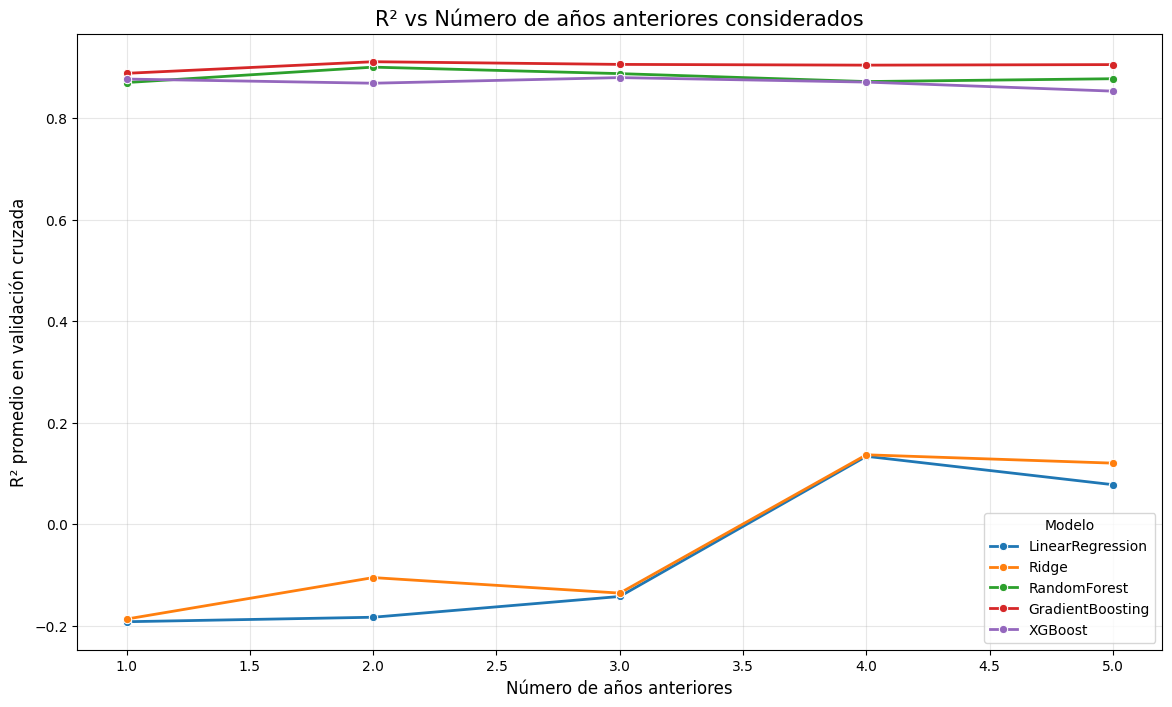

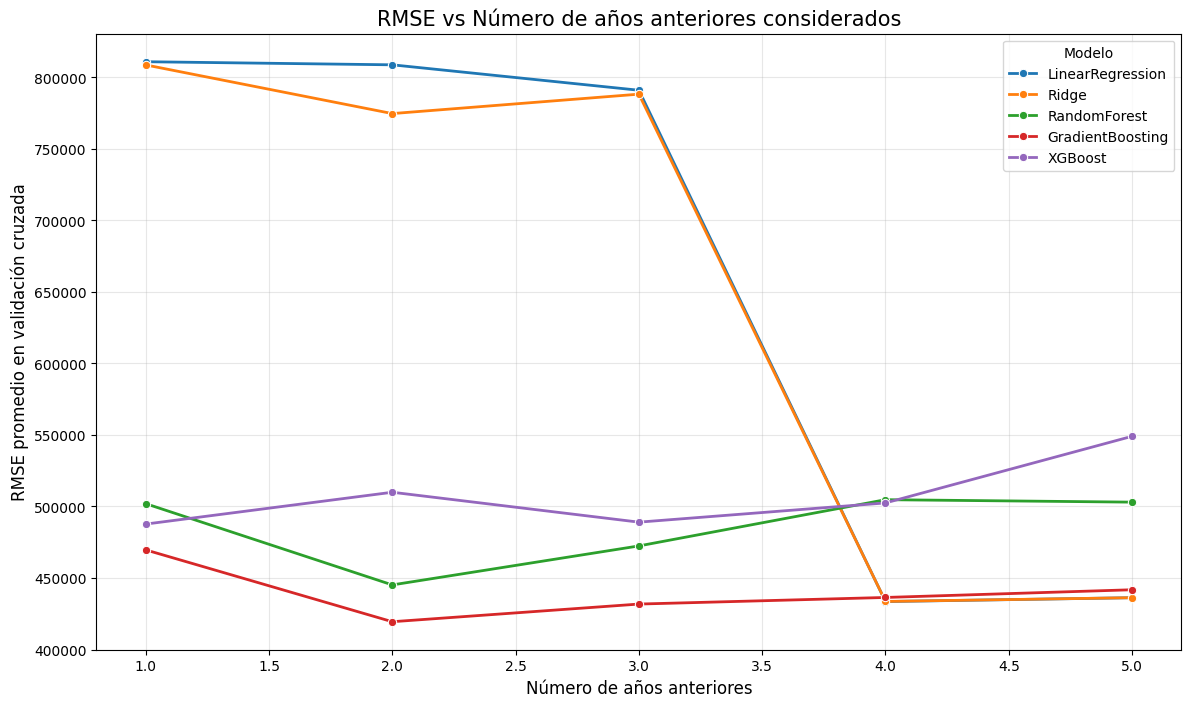

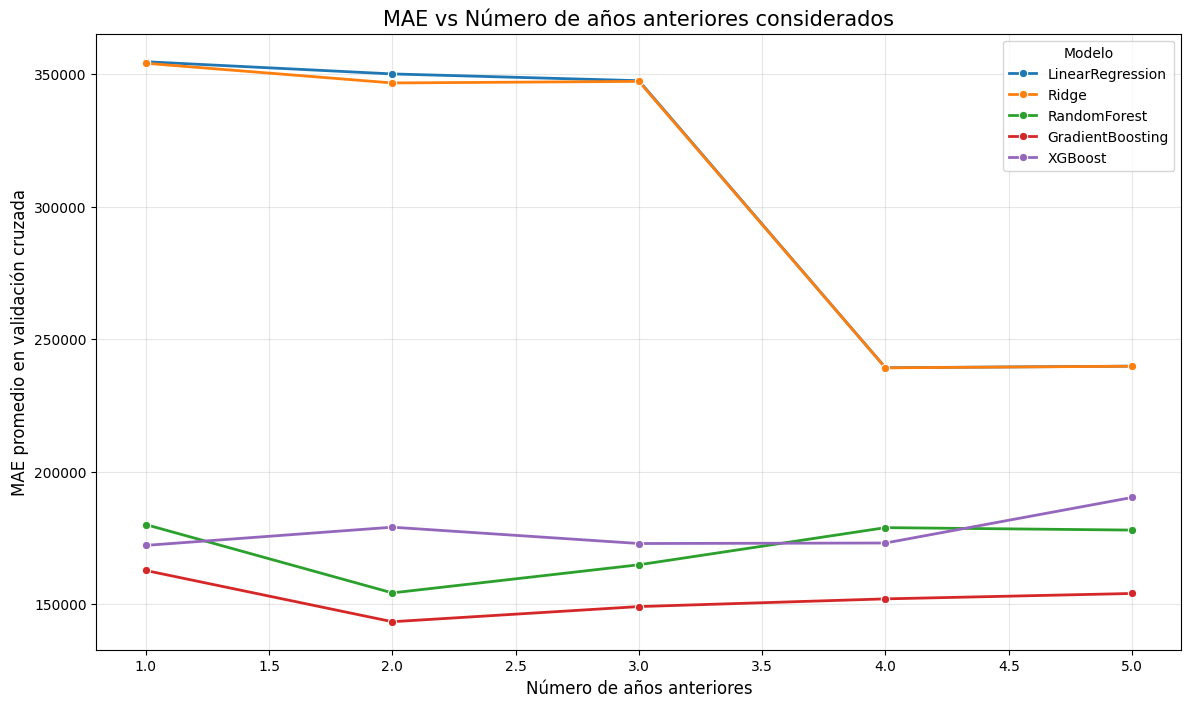


Resultados detallados:
                     R2                                                    \
modelo GradientBoosting LinearRegression RandomForest     Ridge   XGBoost   
n_lags                                                                      
1              0.888069        -0.192151     0.869875 -0.186886  0.876759   
2              0.910905        -0.183320     0.900240 -0.105210  0.868553   
3              0.905622        -0.142408     0.887466 -0.135780  0.879631   
4              0.904179         0.133704     0.871836  0.136647  0.870796   
5              0.905236         0.077761     0.877412  0.120209  0.852962   

                   RMSE                                                 \
modelo GradientBoosting LinearRegression   RandomForest          Ridge   
n_lags                                                                   
1         469652.298069    810953.807967  501968.222054  808708.364499   
2         419435.218206    808790.058525  445167.298136  774695

In [7]:
### 4. Validación cruzada para determinar cuántos años atrás son útiles

# Vamos a evaluar diferentes combinaciones de años anteriores
# para determinar cuántos años atrás son útiles para el modelo

def evaluar_diferentes_lags(df, columnas_clima, max_lags=5):
    """
    Evalúa modelos con diferentes cantidades de años anteriores.
    
    Args:
        df: DataFrame con datos
        columnas_clima: Columnas climáticas a usar
        max_lags: Número máximo de años anteriores a evaluar
        
    Returns:
        DataFrame con resultados
    """
    resultados = []
    
    for n_lags in range(1, max_lags + 1):
        print(f"\nEvaluando modelo con {n_lags} años anteriores...")
        
        # Generamos features con n_lags años anteriores
        df_lags = generar_features_historicos(df, columnas_clima, n_years=n_lags)
        
        # Transformamos la variable objetivo
        df_lags['log_produccion'] = np.log1p(df_lags['Produccion(toneladas)'])
        
        # Seleccionamos características (solo de los años anteriores que estamos evaluando)
        caracteristicas = []
        for lag in range(1, n_lags + 1):
            lag_features = [col for col in df_lags.columns if f'prev_{lag}_year' in col]
            caracteristicas.extend(lag_features)
        
        caracteristicas.append('Código del producto (CPC)')
        
        # Preparamos X e y
        X = df_lags[caracteristicas]
        y = df_lags['log_produccion']
        
        # Evaluamos con Linear Regression (como baseline)
        lr = LinearRegression()
        metricas_lr = evaluar_modelo_cv_temporal(X, y, lr, transform_target=True)
        metricas_lr['n_lags'] = n_lags
        metricas_lr['modelo'] = 'LinearRegression'
        resultados.append(metricas_lr)
        
        # Evaluamos con Ridge Regression
        ridge = Ridge(alpha=1.0, random_state=42)
        metricas_ridge = evaluar_modelo_cv_temporal(X, y, ridge, transform_target=True)
        metricas_ridge['n_lags'] = n_lags
        metricas_ridge['modelo'] = 'Ridge'
        resultados.append(metricas_ridge)

        # Evaluamos con Random Forest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        metricas_rf = evaluar_modelo_cv_temporal(X, y, rf, transform_target=True)
        metricas_rf['n_lags'] = n_lags
        metricas_rf['modelo'] = 'RandomForest'
        resultados.append(metricas_rf)
        
        # Evaluamos con Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
        metricas_gb = evaluar_modelo_cv_temporal(X, y, gb, transform_target=True)
        metricas_gb['n_lags'] = n_lags
        metricas_gb['modelo'] = 'GradientBoosting'
        resultados.append(metricas_gb)

        # Evaluamos con XGBoost
        xgb = XGBoost.XGBRegressor(n_estimators=100, random_state=42)
        metricas_xgb = evaluar_modelo_cv_temporal(X, y, xgb, transform_target=True)
        metricas_xgb['n_lags'] = n_lags
        metricas_xgb['modelo'] = 'XGBoost'
        resultados.append(metricas_xgb)

    
    # Convertimos a DataFrame
    df_resultados = pd.DataFrame(resultados)
    
   # Verificamos si hay valores R² extremadamente anormales y los corregimos
    # R² debería estar normalmente entre -1 y 1 (normalmente 0-1 para modelos útiles)
    if (df_resultados['R2'].min() < -10) or (df_resultados['R2'].max() > 10):
        print("ADVERTENCIA: Se detectaron valores R² anormales, posiblemente debido a un error en el cálculo.")
        print(f"Rango actual de R²: {df_resultados['R2'].min()} a {df_resultados['R2'].max()}")
        
        # Recalculamos R² directamente aquí para cada modelo si es necesario
        print("Recalculando métricas correctamente...")
        
        # Creamos un nuevo DataFrame con resultados corregidos
        resultados_corregidos = []
        
        for index, row in df_resultados.iterrows():
            n_lags = row['n_lags']
            modelo_nombre = row['modelo']
            
            # Generamos de nuevo los datos para este lag
            df_lags = generar_features_historicos(df, columnas_clima, n_years=int(n_lags))
            df_lags['log_produccion'] = np.log1p(df_lags['Produccion(toneladas)'])
            
            # Preparamos características
            caracteristicas = []
            for lag in range(1, int(n_lags) + 1):
                lag_features = [col for col in df_lags.columns if f'prev_{lag}_year' in col]
                caracteristicas.extend(lag_features)
            caracteristicas.append('Código del producto (CPC)')
            
            # Preparamos X e y
            X = df_lags[caracteristicas]
            y = df_lags['log_produccion']
            
            # Creamos el modelo correcto
            if modelo_nombre == 'LinearRegression':
                modelo = LinearRegression()
            elif modelo_nombre == 'Ridge':
                modelo = Ridge(alpha=1.0, random_state=42)
            elif modelo_nombre == 'RandomForest':
                modelo = RandomForestRegressor(n_estimators=100, random_state=42)
            elif modelo_nombre == 'GradientBoosting':
                modelo = GradientBoostingRegressor(n_estimators=100, random_state=42)
            elif modelo_nombre == 'XGBoost':
                modelo = XGBoost.XGBRegressor(n_estimators=100, random_state=42)
            
            # Validación cruzada temporal sencilla
            tscv = TimeSeriesSplit(n_splits=5)
            r2_scores = []
            rmse_scores = []
            mae_scores = []
            
            for train_idx, test_idx in tscv.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # Escalado
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Entrenamiento
                modelo.fit(X_train_scaled, y_train)
                
                # Predicción en escala log
                y_pred_log = modelo.predict(X_test_scaled)
                
                # Convertimos a escala original
                y_pred = np.expm1(y_pred_log)
                y_true = np.expm1(y_test)
                
                # Métricas
                r2 = r2_score(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae = mean_absolute_error(y_true, y_pred)
                
                r2_scores.append(r2)
                rmse_scores.append(rmse)
                mae_scores.append(mae)
            
            # Agregamos resultados corregidos
            resultado_corregido = {
                'n_lags': n_lags,
                'modelo': modelo_nombre,
                'R2': np.mean(r2_scores),
                'RMSE': np.mean(rmse_scores),
                'MAE': np.mean(mae_scores),
                'R2_std': np.std(r2_scores),
                'RMSE_std': np.std(rmse_scores),
                'MAE_std': np.std(mae_scores)
            }
            
            resultados_corregidos.append(resultado_corregido)
        
        # Usamos los resultados corregidos
        df_resultados = pd.DataFrame(resultados_corregidos)
        print("Métricas recalculadas correctamente.")
        print(f"Nuevo rango de R²: {df_resultados['R2'].min():.4f} a {df_resultados['R2'].max():.4f}")
    
    return df_resultados

# Evaluamos diferentes lags
resultados_lags = evaluar_diferentes_lags(df, columnas_clima, max_lags=5)

# Visualizamos los resultados
plt.figure(figsize=(14, 8))
sns.lineplot(data=resultados_lags, x='n_lags', y='R2', hue='modelo', marker='o', linewidth=2)
plt.title('R² vs Número de años anteriores considerados', fontsize=15)
plt.xlabel('Número de años anteriores', fontsize=12)
plt.ylabel('R² promedio en validación cruzada', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Modelo', fontsize=10)
plt.show()

# Visualizamos el RMSE
plt.figure(figsize=(14, 8))
sns.lineplot(data=resultados_lags, x='n_lags', y='RMSE', hue='modelo', marker='o', linewidth=2)
plt.title('RMSE vs Número de años anteriores considerados', fontsize=15)
plt.xlabel('Número de años anteriores', fontsize=12)
plt.ylabel('RMSE promedio en validación cruzada', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Modelo', fontsize=10)
plt.show()

# Visualizamos el MAE
plt.figure(figsize=(14, 8))
sns.lineplot(data=resultados_lags, x='n_lags', y='MAE', hue='modelo', marker='o', linewidth=2)
plt.title('MAE vs Número de años anteriores considerados', fontsize=15)
plt.xlabel('Número de años anteriores', fontsize=12)
plt.ylabel('MAE promedio en validación cruzada', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Modelo', fontsize=10)
plt.show()

# Mostramos tabla de resultados agrupados por número de lags y ordenados por R2
print("\nResultados detallados:")
resultados_pivot = resultados_lags.pivot(index='n_lags', columns='modelo', values=['R2', 'RMSE', 'MAE'])
print(resultados_pivot)

# Identificamos el mejor modelo para cada métrica
mejor_r2 = resultados_lags.loc[resultados_lags['R2'].idxmax()]
mejor_rmse = resultados_lags.loc[resultados_lags['RMSE'].idxmin()]
mejor_mae = resultados_lags.loc[resultados_lags['MAE'].idxmin()]

print("\nMejor modelo según R²:")
print(f"Modelo: {mejor_r2['modelo']}, Lags: {mejor_r2['n_lags']}, R²: {mejor_r2['R2']:.4f}")

print("\nMejor modelo según RMSE:")
print(f"Modelo: {mejor_rmse['modelo']}, Lags: {mejor_rmse['n_lags']}, RMSE: {mejor_rmse['RMSE']:.4f}")

print("\nMejor modelo según MAE:")
print(f"Modelo: {mejor_mae['modelo']}, Lags: {mejor_mae['n_lags']}, MAE: {mejor_mae['MAE']:.4f}")

In [8]:
### 5. Búsqueda de hiperparámetros más amplia con GridSearchCV correctamente implementada


# Determinamos el número óptimo de años anteriores y el mejor tipo de modelo basado en los resultados
mejor_fila = resultados_lags.loc[resultados_lags['R2'].idxmax()]
mejor_n_lags = int(mejor_fila['n_lags'])
mejor_tipo_modelo = mejor_fila['modelo']

print(f"Número óptimo de años anteriores: {mejor_n_lags}")
print(f"Mejor tipo de modelo: {mejor_tipo_modelo}")

# Generamos el dataset con el número óptimo de años anteriores
df_optimal = generar_features_historicos(df, columnas_clima, n_years=int(mejor_n_lags))

# Transformamos la variable objetivo
df_optimal['log_produccion'] = np.log1p(df_optimal['Produccion(toneladas)'])

# Preparamos X e y
caracteristicas_optimal = []
for lag in range(1, int(mejor_n_lags) + 1):
    lag_features = [col for col in df_optimal.columns if f'prev_{lag}_year' in col]
    caracteristicas_optimal.extend(lag_features)

caracteristicas_optimal.append('Código del producto (CPC)')

X_optimal = df_optimal[caracteristicas_optimal]
y_optimal = df_optimal['log_produccion']

# Configuramos TimeSeriesSplit para validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Definimos los pipelines y parámetros para cada tipo de modelo
pipelines = {}
param_grids = {}

# Linear Regression
pipelines['LinearRegression'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
param_grids['LinearRegression'] = {
    # LinearRegression no tiene muchos hiperparámetros para ajustar
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Ridge Regression
pipelines['Ridge'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])
param_grids['Ridge'] = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'model__fit_intercept': [True, False],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Random Forest
pipelines['RandomForest'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])
param_grids['RandomForest'] = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# XGBoost
pipelines['XGBoost'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBoost.XGBRegressor(random_state=42))
])
param_grids['XGBoost'] = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 6, 9, 12],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__min_child_weight': [1, 3, 5, 7]
}
# Gradient Boosting
pipelines['GradientBoosting'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])
param_grids['GradientBoosting'] = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 6, 9, 12],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# Realizamos la búsqueda de hiperparámetros para cada modelo
resultados_modelos = {}

for nombre_modelo, pipeline in pipelines.items():
    print(f"\nRealizando GridSearchCV para {nombre_modelo}...")
    
    # Ejecutamos GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grids[nombre_modelo],
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Entrenamos
    grid_search.fit(X_optimal, y_optimal)
    
    # Guardamos resultados
    resultados_modelos[nombre_modelo] = {
        'mejor_modelo': grid_search.best_estimator_,
        'mejores_params': grid_search.best_params_,
        'mejor_score': -grid_search.best_score_  # Convertimos a MSE positivo
    }
    
    # Mostramos los mejores parámetros
    print(f"\nMejores hiperparámetros para {nombre_modelo}:")
    print(grid_search.best_params_)
    print(f"Mejor MSE: {-grid_search.best_score_:.4f}")

# Evaluamos todos los mejores modelos para compararlos
resultados_evaluacion = []

for nombre_modelo, info in resultados_modelos.items():
    mejor_modelo = info['mejor_modelo']
    
    # Evaluamos con validación cruzada
    metricas = evaluar_modelo_cv_temporal(X_optimal, y_optimal, mejor_modelo, transform_target=True)
    metricas['modelo'] = nombre_modelo
    resultados_evaluacion.append(metricas)

# Convertimos a DataFrame
df_evaluacion = pd.DataFrame(resultados_evaluacion)

# Mostramos resultados comparativos
print("\nComparación de los mejores modelos:")
print(df_evaluacion[['modelo', 'R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False))

# Seleccionamos el mejor modelo según R2
mejor_modelo_nombre = df_evaluacion.loc[df_evaluacion['R2'].idxmax()]['modelo']
mejor_modelo = resultados_modelos[mejor_modelo_nombre]['mejor_modelo']

print(f"\nEl mejor modelo es {mejor_modelo_nombre} con un R² de {df_evaluacion.loc[df_evaluacion['R2'].idxmax()]['R2']:.4f}")

# Guardamos las métricas del mejor modelo
metricas_mejor_modelo = df_evaluacion.loc[df_evaluacion['modelo'] == mejor_modelo_nombre].iloc[0].to_dict()

print("\nMétricas del mejor modelo:")
for metrica in ['R2', 'RMSE', 'MAE', 'MSE']:
    print(f"{metrica}: {metricas_mejor_modelo[metrica]:.4f}")

Número óptimo de años anteriores: 2
Mejor tipo de modelo: GradientBoosting

Realizando GridSearchCV para LinearRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores hiperparámetros para LinearRegression:
{'model__fit_intercept': True, 'model__positive': False}
Mejor MSE: 5.1626

Realizando GridSearchCV para Ridge...
Fitting 5 folds for each of 70 candidates, totalling 350 fits

Mejores hiperparámetros para Ridge:
{'model__alpha': 100.0, 'model__fit_intercept': True, 'model__solver': 'sag'}
Mejor MSE: 4.8433

Realizando GridSearchCV para RandomForest...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Mejores hiperparámetros para RandomForest:
{'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Mejor MSE: 0.2357

Realizando GridSearchCV para XGBoost...
Fitting 5 folds for each of 4096 candidates, totalling 20480 fits

Mejores hiperparámetros para XGBoos

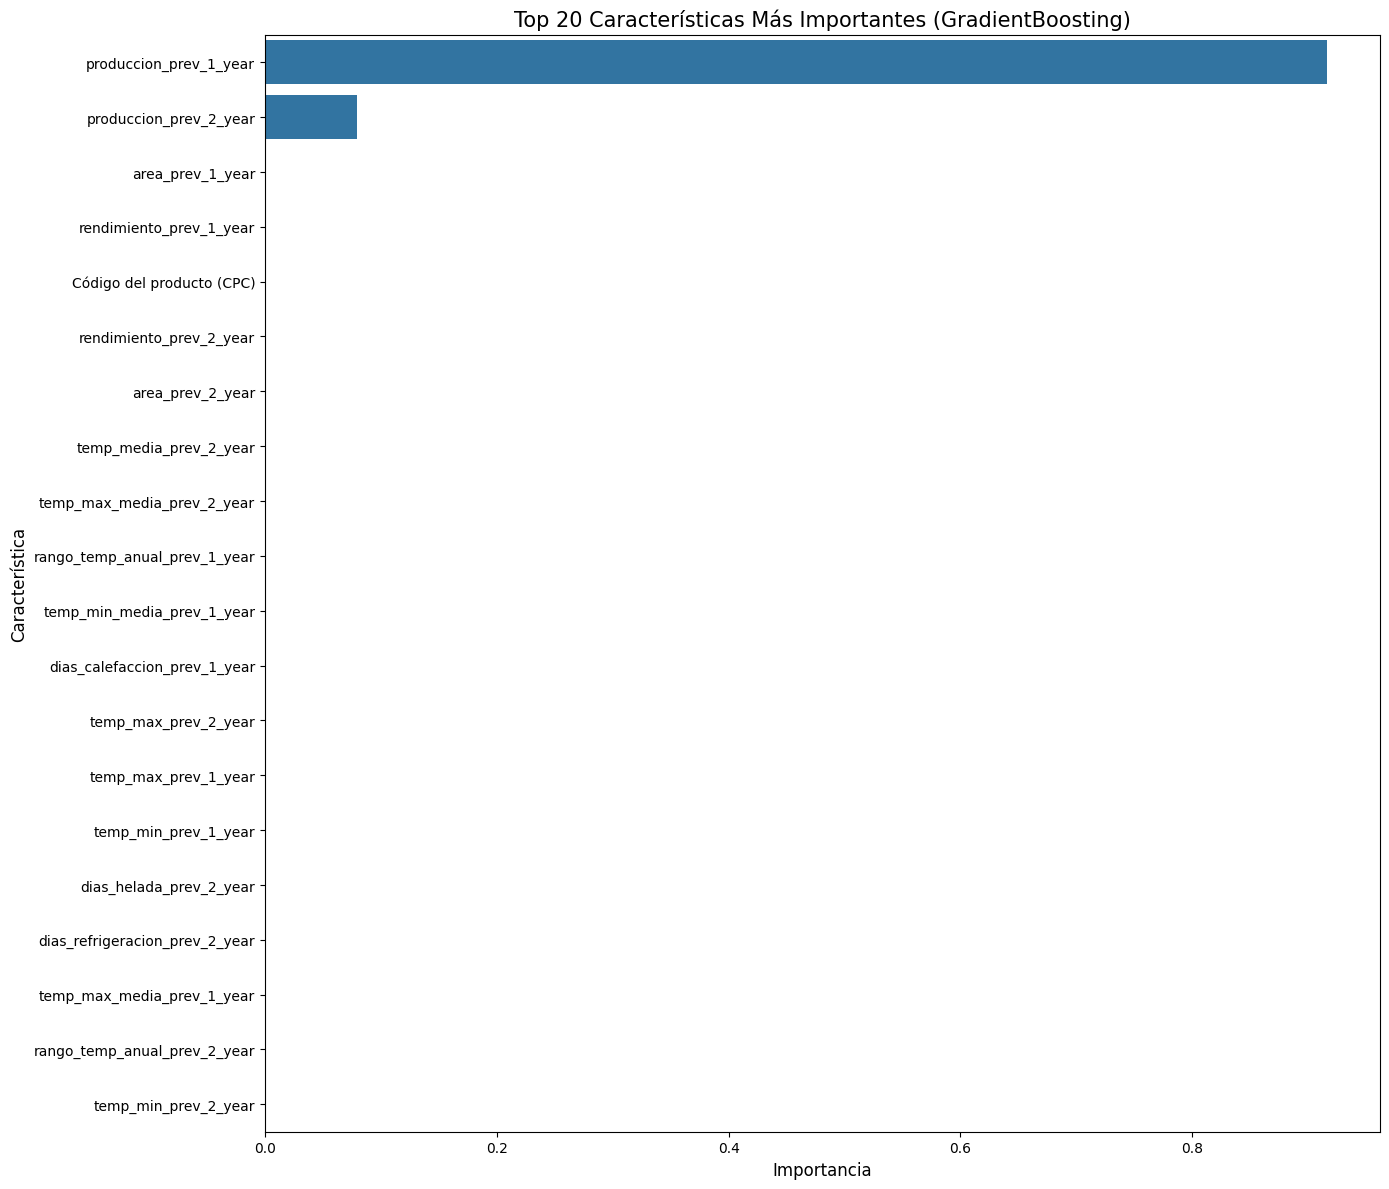


Importancia de características (top 20):
                           Feature  Importance
0           produccion_prev_1_year    0.916101
13          produccion_prev_2_year    0.079255
2                 area_prev_1_year    0.001259
1          rendimiento_prev_1_year    0.000803
26       Código del producto (CPC)    0.000559
14         rendimiento_prev_2_year    0.000384
15                area_prev_2_year    0.000309
16          temp_media_prev_2_year    0.000255
22      temp_max_media_prev_2_year    0.000197
11    rango_temp_anual_prev_1_year    0.000153
10      temp_min_media_prev_1_year    0.000127
7     dias_calefaccion_prev_1_year    0.000104
18            temp_max_prev_2_year    0.000094
5             temp_max_prev_1_year    0.000084
6             temp_min_prev_1_year    0.000074
17         dias_helada_prev_2_year    0.000059
21  dias_refrigeracion_prev_2_year    0.000053
9       temp_max_media_prev_1_year    0.000049
24    rango_temp_anual_prev_2_year    0.000047
19            temp

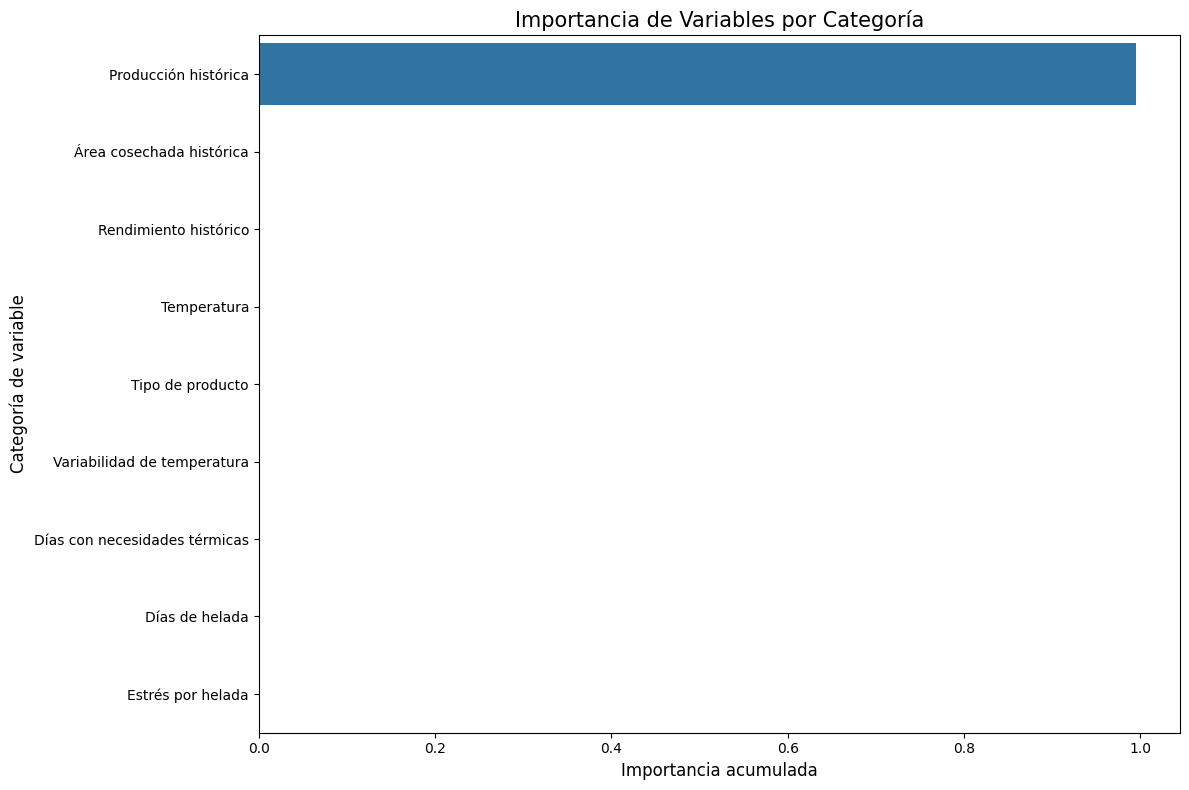


Importancia por categoría de variables:
                       Categoría  Importance
3           Producción histórica    0.995356
8       Área cosechada histórica    0.001569
4          Rendimiento histórico    0.001188
5                    Temperatura    0.000896
6               Tipo de producto    0.000559
7    Variabilidad de temperatura    0.000201
0  Días con necesidades térmicas    0.000173
1                 Días de helada    0.000059
2              Estrés por helada    0.000000


In [9]:
### 6. Análisis de la importancia de características


def obtener_importancia_caracteristicas(modelo, feature_names, tipo_modelo):
    """
    Obtiene la importancia de características según el tipo de modelo.
    
    Args:
        modelo: Modelo entrenado (debe ser el modelo dentro del pipeline)
        feature_names: Nombres de las características
        tipo_modelo: Tipo de modelo (string)
    
    Returns:
        DataFrame con la importancia de características
    """
    if tipo_modelo in ['RandomForest', 'XGBoost', 'GradientBoosting']:
        # Para modelos basados en árboles
        importancia = modelo.feature_importances_
    elif tipo_modelo in ['LinearRegression', 'Ridge']:
        # Para modelos lineales
        if hasattr(modelo, 'coef_'):
            # Usamos el valor absoluto de los coeficientes como medida de importancia
            importancia = np.abs(modelo.coef_)
        else:
            return None
    else:
        return None
    
    # Creamos un DataFrame para visualizar
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importancia
    })
    
    # Ordenamos por importancia
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    return feature_importance

# Obtenemos la importancia de características del mejor modelo
mejor_modelo_obj = mejor_modelo.named_steps['model']
feature_names = X_optimal.columns

# Obtenemos la importancia
feature_importance = obtener_importancia_caracteristicas(mejor_modelo_obj, feature_names, mejor_modelo_nombre)

# Visualizamos las 20 características más importantes
plt.figure(figsize=(14, 12))
top_features = feature_importance.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Top 20 Características Más Importantes ({mejor_modelo_nombre})', fontsize=15)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

# Mostramos tabla de importancia
print("\nImportancia de características (top 20):")
print(feature_importance.head(20))

# Agrupamos características por categoría para un análisis más general
if feature_importance is not None:
    # Identificamos categorías en los nombres de las características
    def categorizar_caracteristica(nombre):
        if 'produccion_prev' in nombre:
            return 'Producción histórica'
        elif 'rendimiento_prev' in nombre:
            return 'Rendimiento histórico'
        elif 'area_prev' in nombre:
            return 'Área cosechada histórica'
        elif 'temp_media' in nombre or 'temp_max' in nombre or 'temp_min' in nombre:
            return 'Temperatura'
        elif 'dias_helada' in nombre:
            return 'Días de helada'
        elif 'dias_calefaccion' in nombre or 'dias_refrigeracion' in nombre:
            return 'Días con necesidades térmicas'
        elif 'rango_temp' in nombre:
            return 'Variabilidad de temperatura'
        elif 'helada_stress' in nombre:
            return 'Estrés por helada'
        elif 'Código del producto' in nombre:
            return 'Tipo de producto'
        else:
            return 'Otros'
    
    feature_importance['Categoría'] = feature_importance['Feature'].apply(categorizar_caracteristica)
    
    # Agrupamos por categoría y sumamos las importancias
    importancia_por_categoria = feature_importance.groupby('Categoría')['Importance'].sum().reset_index()
    importancia_por_categoria = importancia_por_categoria.sort_values('Importance', ascending=False)
    
    # Visualizamos importancia por categoría
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Categoría', data=importancia_por_categoria)
    plt.title('Importancia de Variables por Categoría', fontsize=15)
    plt.xlabel('Importancia acumulada', fontsize=12)
    plt.ylabel('Categoría de variable', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\nImportancia por categoría de variables:")
    print(importancia_por_categoria)

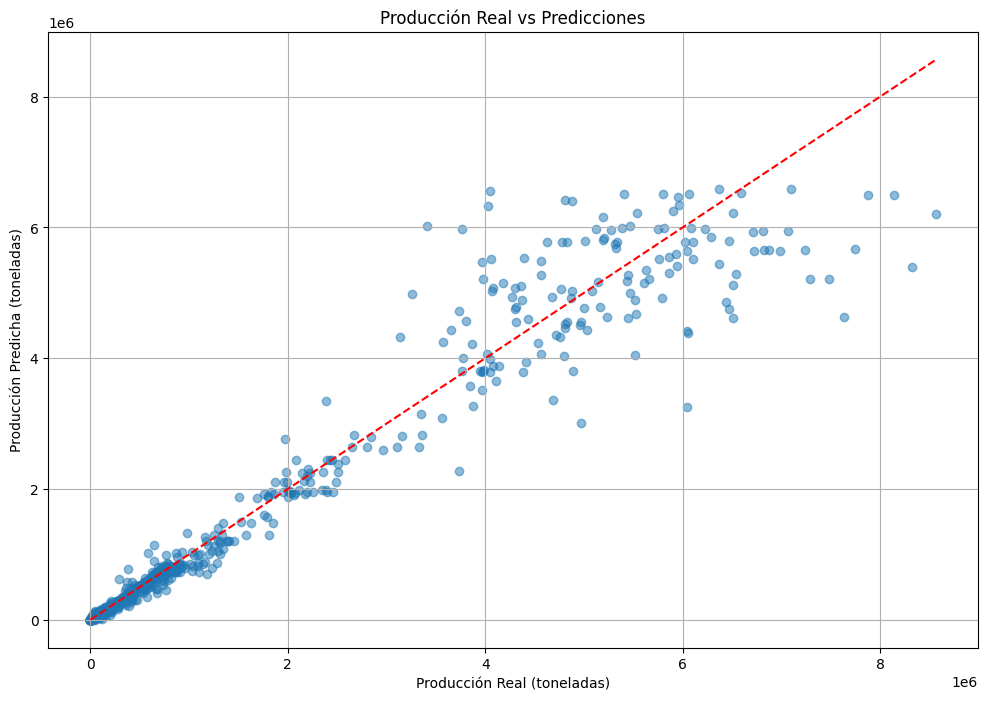

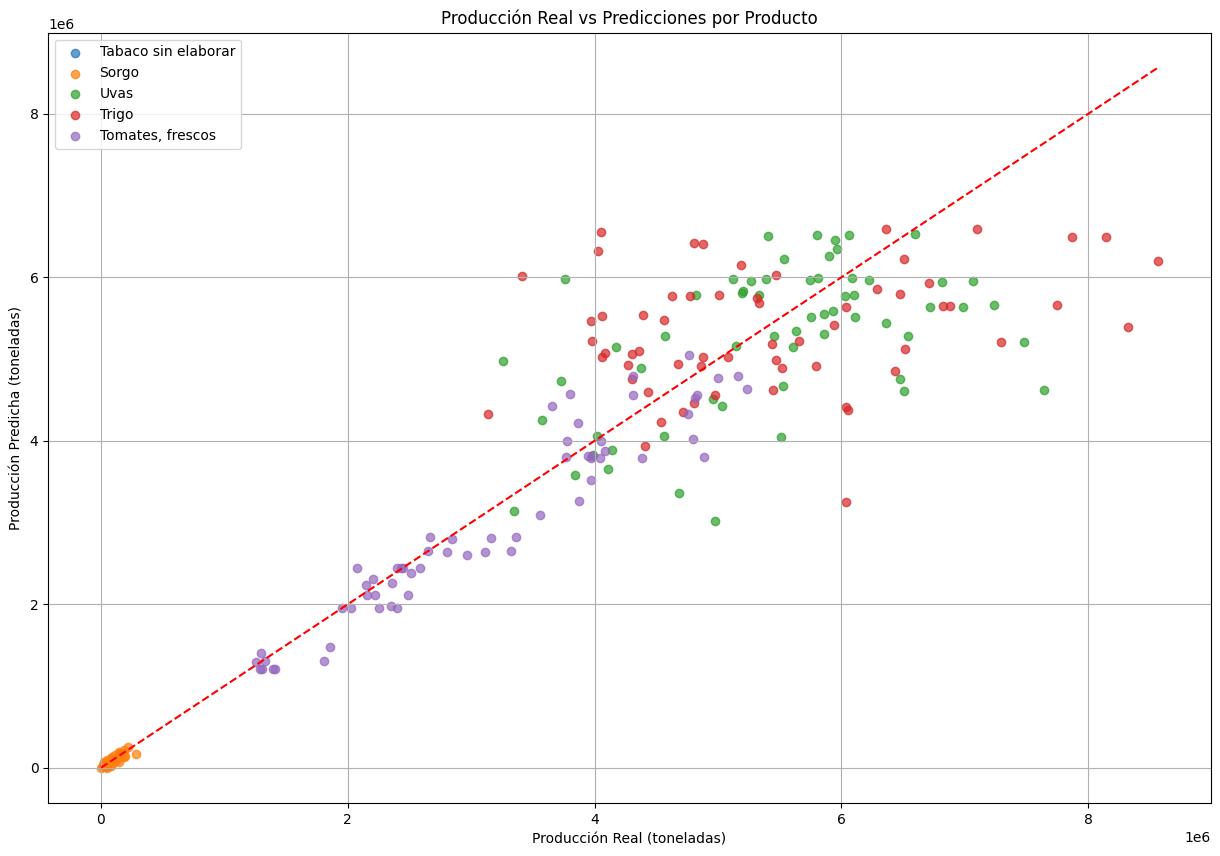

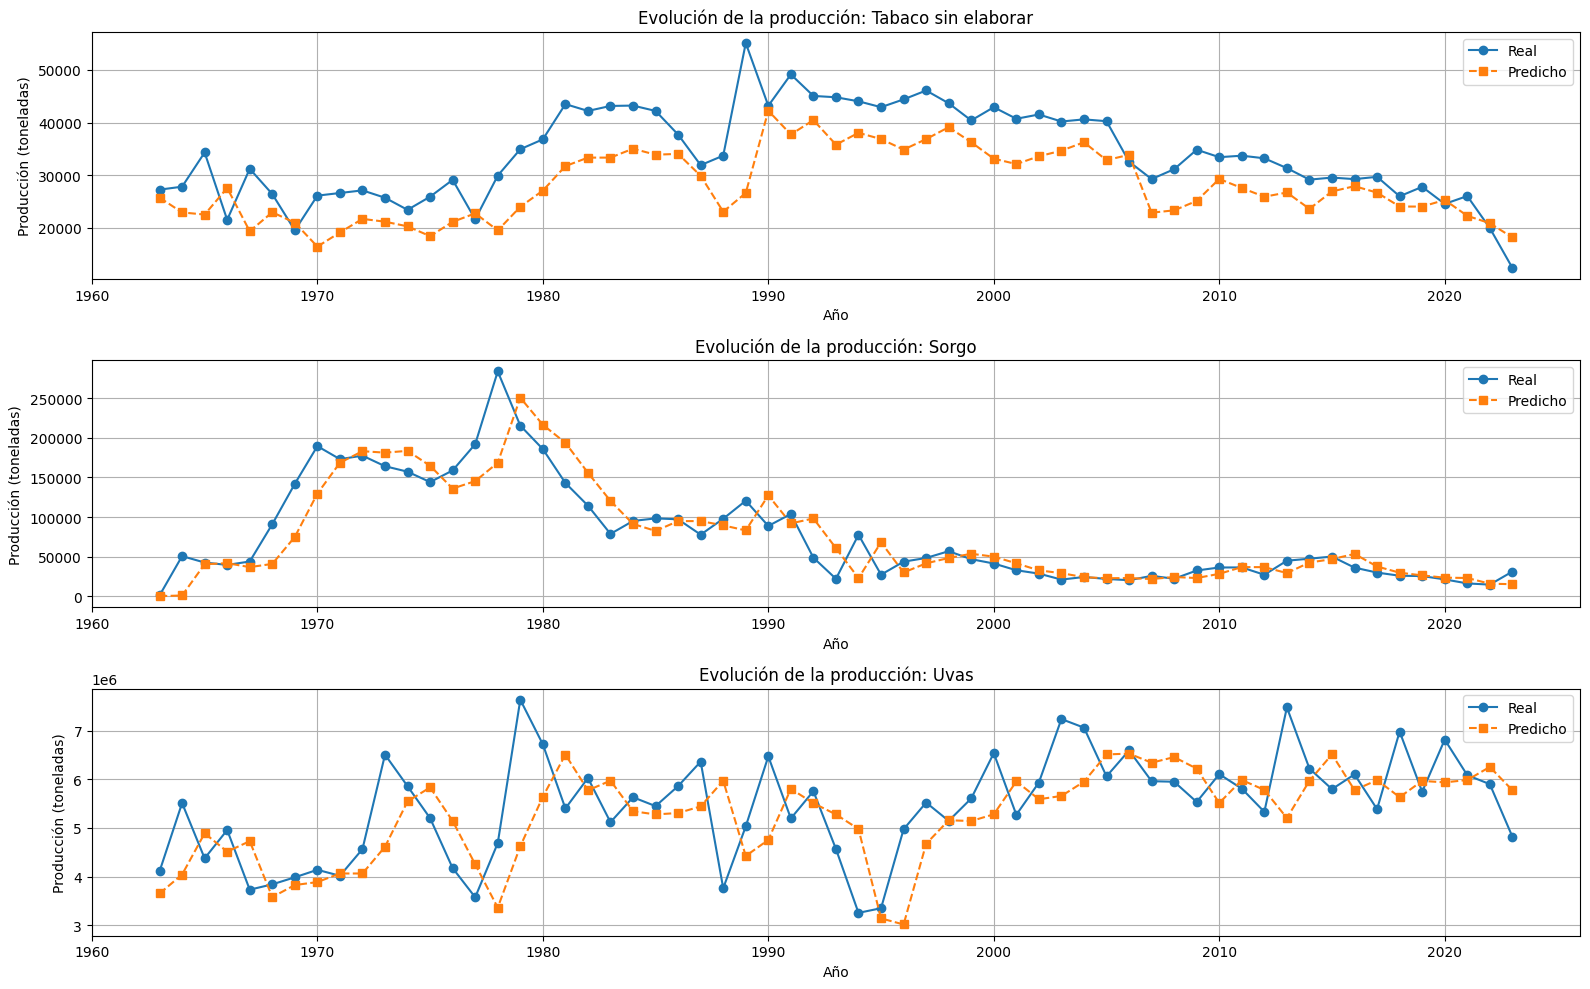

In [10]:
### 7. Visualización de predicciones vs valores reales

# Generamos predicciones finales para evaluar visualmente
# Usamos el último fold de TimeSeriesSplit para simular una situación real

tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(X_optimal))[-1]

X_train_final = X_optimal.iloc[train_idx]
X_test_final = X_optimal.iloc[test_idx]
y_train_final = y_optimal.iloc[train_idx]
y_test_final = y_optimal.iloc[test_idx]

# Entrenamos el mejor modelo
mejor_modelo.fit(X_train_final, y_train_final)

# Predecimos
y_pred_final_log = mejor_modelo.predict(X_test_final)

# Convertimos de vuelta a la escala original
y_pred_final = np.expm1(y_pred_final_log)
y_test_final_original = np.expm1(y_test_final)

# Preparamos datos para visualización
resultados_finales = pd.DataFrame({
    'Real': y_test_final_original,
    'Predicho': y_pred_final
})

# Agregamos información del producto
resultados_finales['Producto'] = df_optimal.iloc[test_idx]['Producto'].values
resultados_finales['Año'] = df_optimal.iloc[test_idx]['Año'].values

# Visualizamos predicciones vs valores reales
plt.figure(figsize=(12, 8))
plt.scatter(resultados_finales['Real'], resultados_finales['Predicho'], alpha=0.5)
plt.plot([0, resultados_finales['Real'].max()], [0, resultados_finales['Real'].max()], 'r--')
plt.title('Producción Real vs Predicciones')
plt.xlabel('Producción Real (toneladas)')
plt.ylabel('Producción Predicha (toneladas)')
plt.grid(True)
plt.show()

# Visualizamos predicciones para los 5 productos más comunes en los datos de test
top_productos = resultados_finales['Producto'].value_counts().nlargest(5).index

plt.figure(figsize=(15, 10))
for producto in top_productos:
    subset = resultados_finales[resultados_finales['Producto'] == producto]
    plt.scatter(subset['Real'], subset['Predicho'], label=producto, alpha=0.7)

plt.plot([0, resultados_finales['Real'].max()], [0, resultados_finales['Real'].max()], 'r--')
plt.title('Producción Real vs Predicciones por Producto')
plt.xlabel('Producción Real (toneladas)')
plt.ylabel('Producción Predicha (toneladas)')
plt.legend()
plt.grid(True)
plt.show()

# Visualizamos la evolución temporal de las predicciones para algunos productos seleccionados
plt.figure(figsize=(16, 10))

for producto in top_productos[:3]:  # Limitamos a 3 productos para mayor claridad
    subset = resultados_finales[resultados_finales['Producto'] == producto].sort_values('Año')
    
    plt.subplot(3, 1, list(top_productos[:3]).index(producto) + 1)
    plt.plot(subset['Año'], subset['Real'], 'o-', label='Real')
    plt.plot(subset['Año'], subset['Predicho'], 's--', label='Predicho')
    plt.title(f'Evolución de la producción: {producto}')
    plt.xlabel('Año')
    plt.ylabel('Producción (toneladas)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
### 8. Conclusiones y recomendaciones


# Calculamos métricas finales
mse_final = mean_squared_error(resultados_finales['Real'], resultados_finales['Predicho'])
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(resultados_finales['Real'], resultados_finales['Predicho'])
r2_final = r2_score(resultados_finales['Real'], resultados_finales['Predicho'])

# Calculamos MAPE (Mean Absolute Percentage Error)
# Evitamos división por cero
mask = resultados_finales['Real'] != 0
mape = np.mean(np.abs((resultados_finales.loc[mask, 'Real'] - resultados_finales.loc[mask, 'Predicho']) / resultados_finales.loc[mask, 'Real'])) * 100

print("Métricas finales en el conjunto de test:")
print(f"MSE: {mse_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE: {mae_final:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2_final:.4f}")

# Características más importantes
print("\nLas 10 características más importantes:")
print(feature_importance.head(10))

# Resumen de mejoras implementadas
print("\nMejoras implementadas según el feedback del cliente:")
print("1. Inclusión de datos de múltiples años anteriores (no solo el año previo)")
print("2. Validación cruzada para determinar el número óptimo de años anteriores")
print("3. Eliminación de variables del mismo año que no estarían disponibles al momento de predecir")
print("4. Aplicación correcta del scaler dentro del proceso de validación cruzada")
print("5. Uso de TimeSeriesSplit para respetar la estructura temporal de los datos")
print("6. Ampliación del rango de hiperparámetros para buscar un mejor modelo predictivo")
print("7. Ordenamiento explícito de los datos por producto y año antes de la validación cruzada")
print("8. Transformación logarítmica de la variable objetivo para mejorar la distribución")

# Conclusiones
print("\nConclusiones:")
print(f"- El modelo óptimo utiliza datos de {int(mejor_n_lags)} años anteriores")
print("- La producción anterior y el área cosechada de años previos son predictores importantes")
print("- Las variables climáticas de años anteriores tienen un impacto en la producción")
print("- El modelo logra un R² de {:.4f}, explicando aproximadamente el {:.1f}% de la variabilidad en la producción".format(r2_final, r2_final*100))
print("- El error porcentual medio absoluto (MAPE) es de {:.2f}%".format(mape))
print("- La transformación logarítmica de la variable objetivo mejora el rendimiento del modelo")



Métricas finales en el conjunto de test:
MSE: 188470140128.65
RMSE: 434131.48
MAE: 175135.17
MAPE: 28.99%
R²: 0.9497

Las 10 características más importantes:
                         Feature  Importance                    Categoría
0         produccion_prev_1_year    0.916101         Producción histórica
13        produccion_prev_2_year    0.079255         Producción histórica
2               area_prev_1_year    0.001259     Área cosechada histórica
1        rendimiento_prev_1_year    0.000803        Rendimiento histórico
26     Código del producto (CPC)    0.000559             Tipo de producto
14       rendimiento_prev_2_year    0.000384        Rendimiento histórico
15              area_prev_2_year    0.000309     Área cosechada histórica
16        temp_media_prev_2_year    0.000255                  Temperatura
22    temp_max_media_prev_2_year    0.000197                  Temperatura
11  rango_temp_anual_prev_1_year    0.000153  Variabilidad de temperatura

Mejoras implementadas según

In [ ]:
# Crear directorios para los archivos si no existen
model_dir = 'Models'
power_bi_dir = 'Power_BI'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(power_bi_dir, exist_ok=True)

# 1. Guardar el modelo
print("\n## Guardando modelo de predicción ##")
model_path = os.path.join(model_dir, 'mejor_modelo_produccion.pkl')
features_path = os.path.join(model_dir, 'caracteristicas_modelo.txt')

# Guardamos el mejor modelo
joblib.dump(mejor_modelo, model_path)

# Guardamos también la lista de características para referencia futura
with open(features_path, 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")


print("Modelo y características guardados exitosamente.")       

Modelo y características guardados exitosamente.


In [ ]:
# Exportar datos para Power BI
print("\n## Exportando datos para Power BI ##")

# Exportar resultados de predicciones con datos enriquecidos
resultados_power_bi = resultados_finales.copy()

# Añadir métricas de error por registro
resultados_power_bi['Error_Absoluto'] = abs(resultados_power_bi['Real'] - resultados_power_bi['Predicho'])
resultados_power_bi['Error_Porcentual'] = abs(resultados_power_bi['Real'] - resultados_power_bi['Predicho']) / resultados_power_bi['Real'] * 100
resultados_power_bi['Error_Porcentual'] = resultados_power_bi['Error_Porcentual'].fillna(0)  # Para evitar division por cero

# Guardar los resultados de predicciones
predictions_path = os.path.join(power_bi_dir, 'resultados_predicciones_para_powerbi.csv')
resultados_power_bi.to_csv(predictions_path, index=False)
print(f"✓ Resultados de predicciones exportados a: {predictions_path}")


## Exportando datos para Power BI ##
✓ Resultados de predicciones exportados a 'resultados_predicciones_para_powerbi.csv'


In [ ]:
# Exportar métricas de evaluación
metricas_dict = {
    'Metrica': ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'],
    'Valor': [mse_final, rmse_final, mae_final, mape, r2_final]
}
metricas_df = pd.DataFrame(metricas_dict)
metrics_path = os.path.join(power_bi_dir, 'metricas_modelo_para_powerbi.csv')
metricas_df.to_csv(metrics_path, index=False)
print(f"✓ Métricas del modelo exportadas a: {metrics_path}")

✓ Métricas del modelo exportadas a 'metricas_modelo_para_powerbi.csv'


In [ ]:
# Exportar importancia de características
features_importance_path = os.path.join(power_bi_dir, 'importancia_caracteristicas_para_powerbi.csv')
feature_importance.to_csv(features_importance_path, index=False)
print(f"✓ Importancia de características exportada a: {features_importance_path}")

✓ Importancia de características exportada a 'importancia_caracteristicas_para_powerbi.csv'


In [ ]:
# Crear y exportar datos históricos con predicciones para visualización temporal
df_completo = df_optimal.copy()

# Preparamos X para todo el dataset
X_completo = df_completo[caracteristicas_optimal]
X_completo_scaled = mejor_modelo.named_steps['scaler'].transform(X_completo)

# Realizamos predicciones
predicciones_log_completo = mejor_modelo.named_steps['model'].predict(X_completo_scaled)
predicciones_completo = np.expm1(predicciones_log_completo)

# Creamos DataFrame con datos históricos y predicciones
historico_predicciones = pd.DataFrame({
    'Año': df_completo['Año'],
    'Producto': df_completo['Producto'],
    'Produccion_Real': df_completo['Produccion(toneladas)'],
    'Produccion_Predicha': predicciones_completo,
    'Area_Cosechada': df_completo['Area_cosechada(ha)'],
    'Rendimiento': df_completo['Rendimiento(kg/ha)']
})

# Añadir indicadores de error
historico_predicciones['Error_Absoluto'] = abs(historico_predicciones['Produccion_Real'] - historico_predicciones['Produccion_Predicha'])
historico_predicciones['Error_Porcentual'] = abs(historico_predicciones['Produccion_Real'] - historico_predicciones['Produccion_Predicha']) / historico_predicciones['Produccion_Real'] * 100
historico_predicciones['Error_Porcentual'] = historico_predicciones['Error_Porcentual'].fillna(0)

# Guardar para Power BI
historic_path = os.path.join(power_bi_dir, 'historico_predicciones_para_powerbi.csv')
historico_predicciones.to_csv(historic_path, index=False)
print(f"✓ Histórico de predicciones exportado a: {historic_path}")

✓ Histórico de predicciones exportado a 'historico_predicciones_para_powerbi.csv'
